# Learn when to buy/sell given observations of 1) recent price history 2) autocorrelogram estimated from the recent price history

The autocorrelogram is in a sense the "best" feature to use as this is the only statistical difference between fractional Brownian motion and regular Brownian motion, for which no trading strategy should be profitable on average. 

To help the network learn a suitable strategy, we provide it with an estimate of the autocorrelogram.

In [1]:
from time import perf_counter

from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from env.rl_trading_env import rl_trading_env
from agent import *

USE_CUDA = False

In [2]:
sns.set()

### Load CSV data

$H=0.7$ : trend-following signal

In [3]:
fname = 'fbm_0700.csv'
dfs = pd.read_csv(fname)

### Load Gym environment

In [4]:
env = rl_trading_env(dfs, 
                     n_lag=100, 
                     n_autocorr=5, 
                     observe_type='autocorr',
                     reward_mode='pnl',
                    )

### Load model

In [5]:
model = MLPAutocorrModel(env.observation_space.shape[0], 
                 env.action_space.n, 
                 use_cuda=USE_CUDA,
                )

### Load agent

In [6]:
learning_rate = 0.01
gamma = 0.8
seed = 1235

config = {
    'env': env,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma,
    'verbose': 10,
    'max_episode_length': 250,
    'use_mean_baseline': True,
    'use_cuda': USE_CUDA,
    'model': model,
}

print("Current config is:")
pprint(config)

agent = REINFORCE(config)

Current config is:
{'env': <env.rl_trading_env.rl_trading_env object at 0x7faf9bd71be0>,
 'gamma': 0.8,
 'learning_rate': 0.01,
 'max_episode_length': 250,
 'model': MLPAutocorrModel(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=12, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=3, bias=True)
    (4): Softmax(dim=-1)
  )
),
 'seed': 1235,
 'use_cuda': False,
 'use_mean_baseline': True,
 'verbose': 10}


/home/sauxpa/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Train

Episode 10/1000: rewards 0.26 +/- 4.9
Episode 20/1000: rewards 0.35 +/- 5.13
Episode 30/1000: rewards -0.58 +/- 5.08
Episode 40/1000: rewards 0.15 +/- 4.43
Episode 50/1000: rewards 0.58 +/- 3.97
Episode 60/1000: rewards 0.63 +/- 4.88
Episode 70/1000: rewards -0.39 +/- 5.09
Episode 80/1000: rewards 0.27 +/- 5.3
Episode 90/1000: rewards 0.53 +/- 5.21
Episode 100/1000: rewards 0.34 +/- 3.75
Episode 110/1000: rewards -0.21 +/- 5.12
Episode 120/1000: rewards 0.34 +/- 5.35
Episode 130/1000: rewards 0.22 +/- 4.02
Episode 140/1000: rewards 0.13 +/- 6.18
Episode 150/1000: rewards 1.29 +/- 5.73
Episode 160/1000: rewards 0.22 +/- 6.73
Episode 170/1000: rewards 1.11 +/- 7.77
Episode 180/1000: rewards -0.06 +/- 8.89
Episode 190/1000: rewards 0.36 +/- 6.72
Episode 200/1000: rewards 0.66 +/- 9.72
Episode 210/1000: rewards 2.61 +/- 11.42
Episode 220/1000: rewards 0.91 +/- 10.56
Episode 230/1000: rewards 0.19 +/- 7.98
Episode 240/1000: rewards 1.07 +/- 6.65
Episode 250/1000: rewards 1.71 +/- 5.93
Episo

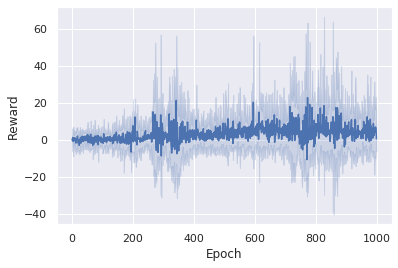

In [7]:
t1_start = perf_counter()  
rewards = agent.train(n_trajectories=15, n_update=1000)
t1_stop = perf_counter() 
print('Elapsed time during training: {:.2f}s'.format(t1_stop-t1_start))

In [8]:
env.render()

Step: 251
Balance: -6532.304097094022
Shares held: 65
Total PnL: -1.6721015193752464 (Max PnL: 12.332584034379579)


In [9]:
agent_trained = agent

## Test on new price paths

In [10]:
fname = 'fbm_0700_test.csv'
dfs = pd.read_csv(fname)
agent = REINFORCE(config)

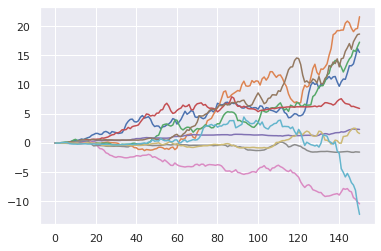

In [11]:
for _ in range(10):
    state = torch.FloatTensor(env.reset())
    done = False
    PnL = []

    while not done:
        action = int(agent.model.select_action(state))
        state, reward, done, _ = env.step(action)
        state = torch.FloatTensor(state)
        PnL.append(reward)
    plt.plot(np.array(PnL).cumsum())    